## Swin Transformer

- 데이터세트는 앞선 ViT 예제의 코드 활용

### GPU 사용 권장

In [1]:
### 앞선 ViT 예제의 코드 - 데이터세트 불러오기 등

from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


train_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 174kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.07MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.5MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [2]:
import torch
from torchvision import transforms
from transformers import AutoImageProcessor

# 모델명 변경
image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
from torch.utils.data import DataLoader


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


train_dataloader = DataLoader(
    subset_train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)
valid_dataloader = DataLoader(
    subset_test_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)

### 스윈 트랜스포머 시작

In [4]:
### 사전 학습된 스윈 트랜스포머 불러오기

from transformers import SwinForImageClassification


model = SwinForImageClassification.from_pretrained(
    pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224",
    num_labels=len(train_dataset.classes),
    id2label={idx: label for label, idx in train_dataset.class_to_idx.items()},
    label2id=train_dataset.class_to_idx,
    ignore_mismatched_sizes=True
)

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                if sssub_name == "projection":
                    print("│  │  └", sssub_name, sssub_module)
                else:
                    print("│  │  └", sssub_name)

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


swin
└ embeddings
│  └ patch_embeddings
│  │  └ projection Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
│  └ norm
│  └ dropout
└ encoder
│  └ layers
│  │  └ 0
│  │  └ 1
│  │  └ 2
│  │  └ 3
└ layernorm
└ pooler
classifier


- 스윈 트랜스포머는 크게 swin과 classifier로 구분됨
  - swin: 패치 파티션, 선형 임베딩과 함께 0, 1, 2, 3 스테이지 수행
  - 스테이지 이후 계층 정규화(layernorm), 풀링(pooler) 통과
  - classifier: 클래스 구분
- 패치 파티션, 선형 임베딩: model.swin.embeddings.patch_embeddings에서 수행됨
  - patch_embeddings 에서 수행되는 합성곱 계층: (4, 4) 커널, 4 스트라이드 확인 가능
  - 224*224 이미지 적용 시: (224-4)/4 + 1 = 56. 즉, 56*56 텐서 생성 -> 일렬 나열 시 3,136 패치
    

In [5]:
### 패치 임베딩 모듈

batch = next(iter(train_dataloader))
print("이미지 차원 :", batch["pixel_values"].shape)

patch_emb_output, shape = model.swin.embeddings.patch_embeddings(batch["pixel_values"])
print("모듈:", model.swin.embeddings.patch_embeddings)
print("패치 임베딩 차원 :", patch_emb_output.shape)

이미지 차원 : torch.Size([32, 3, 224, 224])
모듈: SwinPatchEmbeddings(
  (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
)
패치 임베딩 차원 : torch.Size([32, 3136, 96])


- 스윈 트랜스포머는 [CLS] 토큰 사용 X
  - 토큰들의 평균값을 사용해 분류 진행
  - 스윈 트랜스포머는 객체 검출 등에서 여러 물체가 포함될 경우 [CLS] 토큰 하나로 처리 어려움

In [6]:
### 스윈 트랜스포머 블록
# 첫 번째 스테이지의 스윈 트랜스포머 출력

for main_name, main_module in model.swin.encoder.layers[0].named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│ └", ssub_name)

blocks
└ 0
│ └ layernorm_before
│ └ attention
│ └ drop_path
│ └ layernorm_after
│ └ intermediate
│ └ output
└ 1
│ └ layernorm_before
│ └ attention
│ └ drop_path
│ └ layernorm_after
│ └ intermediate
│ └ output
downsample
└ reduction
└ norm


- 스윈 트랜스포머의 스테이지: blocks, downsample로 이루어짐
  - blocks: 스윈 트랜스포머 블록
    - Swinlayer-0: W-MSA
    - Swinlayer-1: SW-MSA
  - downsample: 패치 병합

In [7]:
### Swinlayer 구조

print(model.swin.encoder.layers[0].blocks[0])

SwinLayer(
  (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (attention): SwinAttention(
    (self): SwinSelfAttention(
      (query): Linear(in_features=96, out_features=96, bias=True)
      (key): Linear(in_features=96, out_features=96, bias=True)
      (value): Linear(in_features=96, out_features=96, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (output): SwinSelfOutput(
      (dense): Linear(in_features=96, out_features=96, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (drop_path): Identity()
  (layernorm_after): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (intermediate): SwinIntermediate(
    (dense): Linear(in_features=96, out_features=384, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): SwinOutput(
    (dense): Linear(in_features=384, out_features=96, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)


- SwinLayer: 기본적인 빌딩 블록이 되는 계층 / 스윈 트랜스포머 블록을 의미
- 계층 정규화 -> MSA -> 계층 정규화 -> MLP의 순서로 수행
- layernorm_before: 첫 번째 계층 정규화
- attention: MSA
- layernorm_after: 두 번째 계층 정규화
- intermediate, output: MLP
  - 두 개의 연속된 선형 변환 계층과 GELU(Gaussian Error Linear Unit) 활성화 함수로 구성
  - GELU: ReLU와 형태 유사 / 가우시안 분포에 대한 누적 분포 함수 / 입력값이 0 주변에서 부드럽게 변화
  - ReLU를 사용했을 때보다 더 안정적인 학습

In [8]:
### W-MSA, SW-MSA 모듈

print("패치 임베딩 차원 :", patch_emb_output.shape)

W_MSA = model.swin.encoder.layers[0].blocks[0]
SW_MSA = model.swin.encoder.layers[0].blocks[1]

W_MSA_output = W_MSA(patch_emb_output, W_MSA.input_resolution)[0]
SW_MSA_output = SW_MSA(W_MSA_output, SW_MSA.input_resolution)[0]

print("W-MSA 결과 차원 :", W_MSA_output.shape)
print("SW-MSA 결과 차원 :", SW_MSA_output.shape)

패치 임베딩 차원 : torch.Size([32, 3136, 96])
W-MSA 결과 차원 : torch.Size([32, 3136, 96])
SW-MSA 결과 차원 : torch.Size([32, 3136, 96])


In [9]:
### 패치 병합

patch_merge = model.swin.encoder.layers[0].downsample
print("patch_merge 모듈 :", patch_merge)

output = patch_merge(SW_MSA_output, patch_merge.input_resolution)
print("patch_merge 결과 차원 :", output.shape)

patch_merge 모듈 : SwinPatchMerging(
  (reduction): Linear(in_features=384, out_features=192, bias=False)
  (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
)
patch_merge 결과 차원 : torch.Size([32, 784, 192])


## 모델 학습: 사실상 이것만 실행해도 무관
### (def로 앞서 한 것들 다시 다 정의)

In [11]:
# !pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [13]:
### 스윈 트랜스포머 모델 학습
# ViT 모델 학습 코드를 일부만 변경 (변경 부분 표시)

import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import SwinForImageClassification  # 변경
from transformers import TrainingArguments, Trainer


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


# 변경
def model_init(classes, class_to_idx):
    model = SwinForImageClassification.from_pretrained(
        pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True
    )
    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1


train_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

# 변경됨
args = TrainingArguments(
    output_dir="../models/Swin-FashionMNIST",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs_dir",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7,
    report_to="none" # 코랩인 경우(API 키 입력 안해도 되게)
)

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
<ipython-input-13-1587ddc13a25>:114: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SwinForImageClassification were not initialized from the model ch

Epoch,Training Loss,Validation Loss,F1
1,0.339100,0.298284,0.888496
2,0.242200,0.250687,0.911350
3,0.214000,0.227676,0.924034


TrainOutput(global_step=1875, training_loss=0.3606236002604167, metrics={'train_runtime': 433.0763, 'train_samples_per_second': 69.272, 'train_steps_per_second': 4.329, 'total_flos': 7.4584635826176e+17, 'train_loss': 0.3606236002604167, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 8.437071  , -2.8429759 , -0.17569162, ..., -2.3121157 ,
        -1.6183759 , -2.041729  ],
       [ 4.9663606 ,  0.49973008,  0.9761899 , ..., -1.8285545 ,
        -0.8092779 , -2.8122244 ],
       [ 7.691373  , -3.1449099 , -0.5298784 , ..., -1.4806358 ,
         0.365517  , -1.6946573 ],
       ...,
       [-1.0550084 , -3.0790815 , -1.9771148 , ...,  0.9480287 ,
         0.9560779 ,  4.3130393 ],
       [-0.5130682 , -3.1393309 , -1.6621631 , ...,  1.5516957 ,
        -2.8562317 ,  9.115422  ],
       [-1.8895687 , -1.8541348 , -1.5260773 , ..., -1.2561363 ,
        -1.5494204 ,  7.9098396 ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

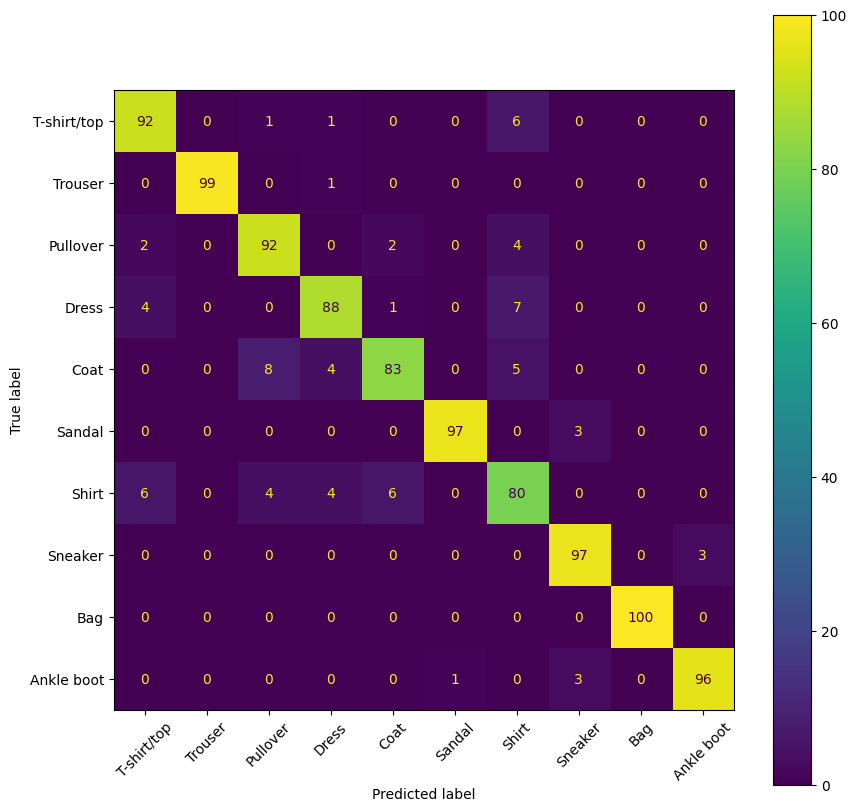

In [14]:
### 출력 결과(ViT의 성능평가 활용)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_, ax = plt.subplots(figsize=(10, 10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()